HEASARC Pre-curated Suzaku Light Curve data set

This notebook provides a demonstration of how to work with pre-curated HEASARC data sets. We conduct a basic exploratory data analysis and unsupervised machine learning.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.time import TimeDelta
import lightkurve as lk

change to your path containing HEASARC pre-curated data

In [4]:
path='/efs/STG_Tutorial_Data/Astro_CNN/'
weightpath='./model_weights/'

Open pre-curated HEASARC data containing all Suzaku light curves

In [5]:
fp=open(path+'suzaku_lcs_p5_2.pkl','rb');lcs_soft=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lcs_2_10.pkl','rb');lcs_hard=pickle.load(fp);fp.close()
fp=open(path+'suzaku_times_p5_2.pkl','rb');times=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lc_tgtlabels.pkl','rb');tgtlabels=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lc_tstarts.pkl','rb');tstarts=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lc_ra.pkl','rb');ra=pickle.load(fp);fp.close()
fp=open(path+'suzaku_lc_dec.pkl','rb');dec=pickle.load(fp);fp.close()

In order to group observations of the same target, find unique target names. Note that this is not a perfect method as the same target may be named with slight differences in different observations.  For a slightly more complete solution (though more difficult to work with the names, so we will avoid it here) keep only alphanumeric characters and change letters to lowercase with this command:
tgtlabels=np.array([''.join([i for i in t if i.isalpha() or i.isnumeric()]).lower() for t in tgtlabels])

In [6]:
tgtlabels=np.array(tgtlabels)
tgtlabels_unique=np.unique(tgtlabels).tolist()

All loaded data files are in list format.  Change to numpy arrays for more functionality.

In [7]:
lcs_hard=np.array(lcs_hard)
lcs_soft=np.array(lcs_soft)
times=np.array(times)
tstarts=np.array(tstarts)
ra=np.array(ra)
dec=np.array(dec)

/tmp/ipykernel_3716/4089444729.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lcs_hard=np.array(lcs_hard)
/tmp/ipykernel_3716/4089444729.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lcs_soft=np.array(lcs_soft)
/tmp/ipykernel_3716/4089444729.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  times=np.array(times)


Calulate the mean and variance of each light curve

In [8]:
means=[]
variances=[]
for i in range(lcs_hard.shape[0]):
    means.append(lcs_hard[i].mean())
    variances.append(lcs_hard[i].var())

/tmp/ipykernel_3716/1907329048.py:4: RuntimeWarning: Mean of empty slice.
  means.append(lcs_hard[i].mean())
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3716/1907329048.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  variances.append(lcs_hard[i].var())
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


This operation creates some NaNs, so let's turn the data into a Pandas data frame and get rid of them.

In [9]:
df=pd.DataFrame(means,columns=['means'])
df['variances']=variances
df['tgt']=tgtlabels
df=df.dropna()

Let's find some highly variable sources. Plot the mean vs. the variance of each light curve.

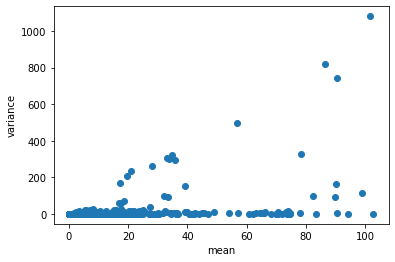

In [10]:
plt.scatter(df['means'],df['variances']);
plt.xlabel('mean');
plt.ylabel('variance');

A large variance by itself could just be indicative of a bright source, so plotting variance against the mean allows to see outliers.  There is a linear trend along the upper limit here, which is what we would expect to see, so no particularly extreme behavioral outliers.  To bring the data to a more manageable scale, let's look at ita different way, plotting the mean against the variance divided by the mean.

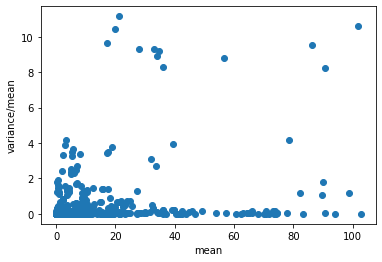

In [11]:
plt.scatter(df['means'],df['variances']/df['means']);
plt.xlabel('mean');
plt.ylabel('variance/mean');

A much nicer plot!  What are the particularly variable sources, say, with a variance to mean ratio greater than 6?

In [12]:
dfpart=df[df['variances']/df['means']>6.]
dfpart

,means,variances,tgt
48,86.261841,821.946289,Crab Nebula
50,56.689869,498.084229,Crab Nebula
52,101.655304,1080.922607,Crab Nebula
54,90.539299,744.080322,Crab Nebula
1864,33.852650,301.060211,VELA X-1
1865,32.991039,306.393097,VELA X-1
1866,34.838890,321.340668,VELA X-1
2458,19.697474,205.966934,HERCULES X-1
2459,17.237900,166.648941,HERCULES X-1
2460,21.055851,234.988724,HERCULES X-1


These are all very well known sources.  Perhaps a less extreme group will contain a source to examine.

In [13]:
dfpart=df[(df['variances']/df['means']>4.) & (df['variances']/df['means']<6.)]
dfpart

,means,variances,tgt
295,78.404800,325.602386,CYG X-1
2272,3.251133,13.476431,4U0114+65


Everyone knows Cyg X-1, so let's take a closer look at 4U 0114+65.  I want to plot ALL the available data, not just a single observation, so I need to combine all the observations of the target into a single array.  In fact, let's just do it for all the targets.

In [14]:
lcs_hard_joined=[lcs_hard[tgtlabels==t] for t in tgtlabels_unique]
lcs_soft_joined=[lcs_soft[tgtlabels==t] for t in tgtlabels_unique]
times_joined=[times[tgtlabels==t] for t in tgtlabels_unique]
tstarts_joined=[tstarts[tgtlabels==t] for t in tgtlabels_unique]
ra_joined=[ra[tgtlabels==t] for t in tgtlabels_unique]
dec_joined=[dec[tgtlabels==t] for t in tgtlabels_unique]

joined_means=[]
joined_variances=[]
for i in range(len(lcs_hard_joined)):
    joined_means.append(np.hstack((lcs_hard_joined[i])).mean())
    joined_variances.append(np.hstack((lcs_hard_joined[i])).var())
    
df_joined=pd.DataFrame(joined_means,columns=['means'])
df_joined['variances']=joined_variances
df_joined['tgt']=tgtlabels_unique
df_joined=df_joined.dropna()

/tmp/ipykernel_3716/1509172600.py:11: RuntimeWarning: Mean of empty slice.
  joined_means.append(np.hstack((lcs_hard_joined[i])).mean())
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3716/1509172600.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice
  joined_variances.append(np.hstack((lcs_hard_joined[i])).var())
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Suzaku time is in seconds since 01-01-2000.  So, create a function that converts all the times to JD.

In [15]:
t_suzaku_start=Time('2000-01-01')
def timeconvert(idx,hs='hard'):
    tpart=times_joined[idx]
    if hs=='soft':
        fpart=lcs_soft_joined[idx]
    elif hs=='hard':
        fpart=lcs_hard_joined[idx]
    elif hs=='ratio':
        fpart=lcs_hard_joined[idx]/lcs_soft_joined[idx]
    tspart=tstarts_joined[idx]
    tjpart=[]
    for t,ts in zip(tpart,tspart):
        td=TimeDelta(t,format='sec')+t_suzaku_start+TimeDelta(ts,format='sec')
        for d in td:
            tjpart.append(d.isot)
    fjpart=np.hstack(fpart)
    return tjpart,fjpart

Using the "lightkurve" library, which offers a lot of neat functionality, create a LightCurve object of all the observations of 4U 0114.65

In [16]:
lc=lk.LightCurve(time=Time(timeconvert(tgtlabels_unique.index('4U0114+65'))[0], format='isot', scale='utc').jd,flux=timeconvert(tgtlabels_unique.index('4U0114+65'))[1])

And plot...

In [17]:
Time(timeconvert(tgtlabels_unique.index('4U0114+65'))[0], format='isot', scale='utc').jd

array([2455763.9802631 , 2455763.98100384, 2455763.98174458, ...,
       2455765.44248532, 2455765.44322607, 2455765.44396681])

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

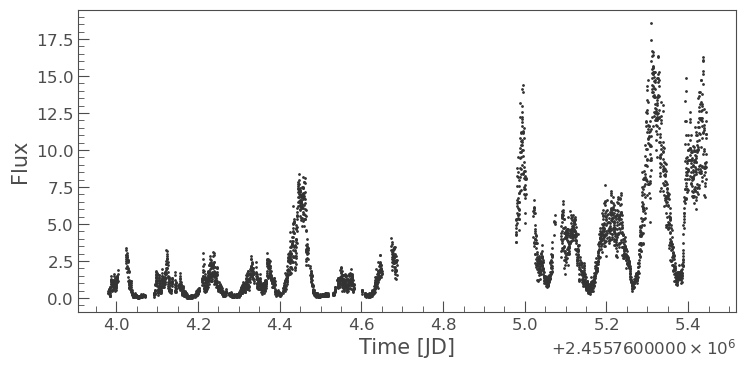

In [18]:
lc.scatter()

To show just one of the fun things the lightkurve package can do, let's convert this to a periodogram.

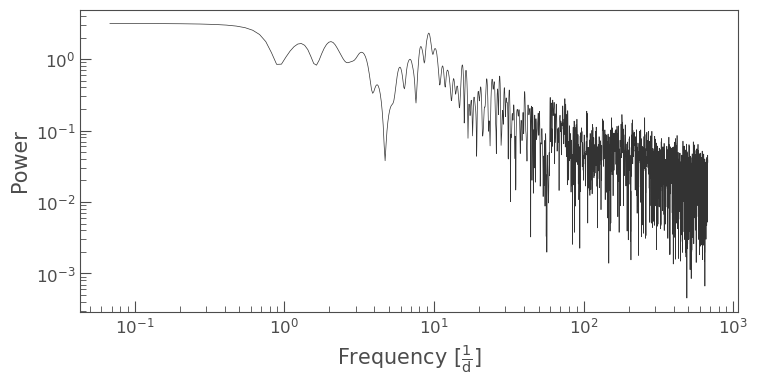

In [19]:
p=lc.to_periodogram(oversample_factor=10);
p.plot(scale='log',view='frequency');

Convert this to view the period instead of the frequency

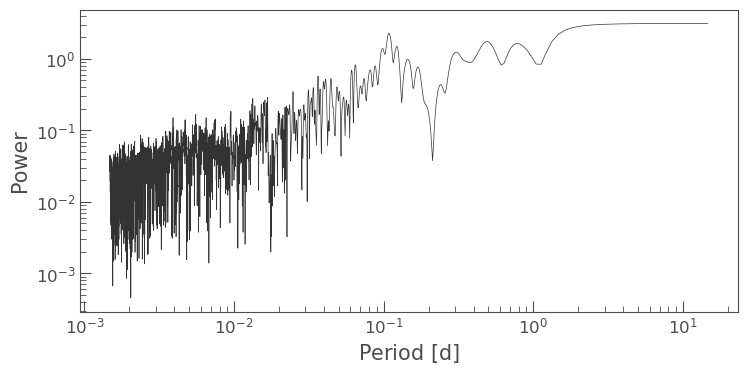

In [20]:
p.plot(scale='log',view='period');

Cool!  The periodogram is neat, but doesn't really show us a great period for this data.  What are the top twenty options?

In [21]:
p.period[p.power.argsort()[::-1]][:20]

<Quantity [14.63703704,  7.31851852,  4.87901235,  3.65925926,  2.92740741,
            2.43950617,  2.09100529,  1.82962963,  1.62633745,  0.1084225 ,
            0.10762527,  0.10923162,  1.4637037 ,  0.10683969,  0.11005291,
            0.11088664,  0.10606549,  0.11173311,  0.10530242,  0.48790123] d>

Looking back at the light curve, it seems that the period of the X-ray outburst is about every .1 days.  So, from these options, I'm guessing .1084255 days is the best choice.  Does this correspond to existing analysis? Let's look it up using NASA's Astrophysics Data System (ADS) API.

Time to move on to some machine learning.  For any type of machine learning analysis, the data must be the same shape.  Turn all the pre-curated light curves into length 64 (arbitrary choice, pick whatever suits your analysis).

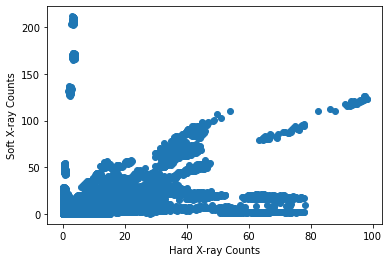

In [22]:
hlcs=[lc for lc in lcs_hard if len(lc)>=64]
hlcs=np.array([lc[:64] for lc in hlcs])
slcs=[lc for lc in lcs_soft if len(lc)>=64]
slcs=np.array([lc[:64] for lc in slcs])
tgts=[t for t,lc in zip(tgtlabels,lcs_hard) if len(lc)>=64]
tgts=np.array(tgts)
tgts=np.vstack(([tgts for i in range(64)]))
tgts=tgts.T
hlcs_flat=hlcs.flatten()
slcs_flat=slcs.flatten()
tgts_flat=tgts.flatten()
hmask=(hlcs_flat==np.nan) | (hlcs_flat==np.inf) 
smask=(slcs_flat==np.nan) | (slcs_flat==np.inf) 
mask=hmask | smask
mask=1.-mask
mask=mask.astype(bool)
hlcs_flat=hlcs_flat[mask]
slcs_flat=slcs_flat[mask]
tgts_flat=tgts_flat[mask]
plt.scatter(hlcs_flat,slcs_flat)
plt.xlabel('Hard X-ray Counts');
plt.ylabel('Soft X-ray Counts');

In a quick look at the data, there are some outliers worth examining.  Check out the group with huge soft X-ray counts and negligible hard X-ray counts

In [23]:
tgts_flat[slcs_flat>200] 

array(['PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK',
       'PUP A : BEK', 'PUP A : BEK', 'PUP A : BEK', 'PUP A : B

Looks like these data points all belong to Puppis A.  Plot the hard and soft X-ray light curves.

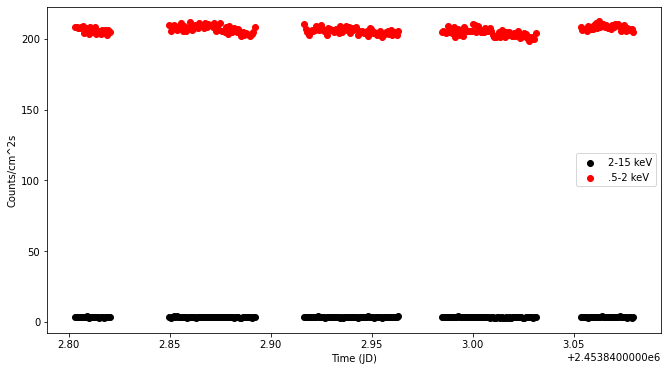

In [24]:
idx=tgtlabels_unique.index('PUP A : BEK')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend();
plt.xlabel('Time (JD)');
plt.ylabel('Counts/cm^2s');

Wow, the supernova remnant Puppis A emits nearly all soft X-rays! Let's see what ADS knows about this.

Let's check out the other extreme, hard X-rays.

In [25]:
tgts_flat[hlcs_flat>80] 

array(['CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1',
       'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1',
       'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1',
       'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1', 'CYG X-1',
       'CYG X-1'], dtype='<U24')

And, of course, we find the other extreme occupied by the famous black hole, Cyg X-1.  Plot it.

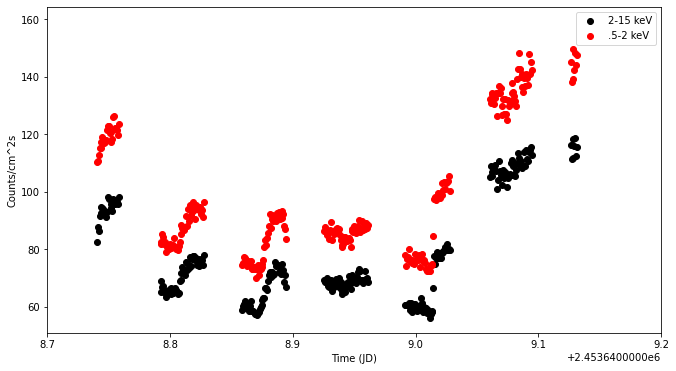

In [26]:
idx=tgtlabels_unique.index('CYG X-1')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend();
plt.xlim(2453648.7,2453649.2);
plt.xlabel('Time (JD)');
plt.ylabel('Counts/cm^2s');

Nothing outstanding in terms of hard/soft ratio, but we see that Cyg X-1 is very X-ray bright through the entire spectrum.  Speaking of hard/soft ratio, perhaps the hardness ratios are worth examining.

In [27]:
hardness_ratio=hlcs_flat/slcs_flat
mask=(hardness_ratio==np.nan) | (hardness_ratio==np.inf) 
mask=1.-mask
mask=mask.astype(bool)
hlcs_flat=hlcs_flat[mask]
slcs_flat=slcs_flat[mask]
tgts_flat=tgts_flat[mask]
hardness_ratio=hardness_ratio[mask]

/tmp/ipykernel_3716/4142093135.py:1: RuntimeWarning: divide by zero encountered in true_divide
  hardness_ratio=hlcs_flat/slcs_flat
/tmp/ipykernel_3716/4142093135.py:1: RuntimeWarning: invalid value encountered in true_divide
  hardness_ratio=hlcs_flat/slcs_flat


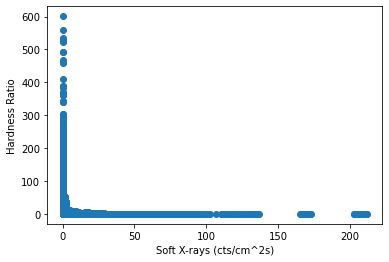

In [28]:
plt.scatter(slcs_flat,hardness_ratio)
plt.xlabel('Soft X-rays (cts/cm^2s)');
plt.ylabel('Hardness Ratio');

We are not interested in the hardness ratios for soft X-rays less than 1, as the hardness ratio will be excessively large

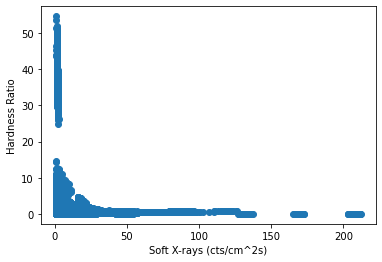

In [29]:
plt.scatter(slcs_flat[slcs_flat>1.],hardness_ratio[slcs_flat>1.])
plt.xlabel('Soft X-rays (cts/cm^2s)');
plt.ylabel('Hardness Ratio');

We can easily pick out very hard or very soft X-ray emitters from this plot, but I'm more interested in the change in hardness ratio.  So, plot the mean and variance.

In [30]:
hardness_ratio_g1=hardness_ratio[slcs_flat>1.]
tgts_flat_g1=tgts_flat[slcs_flat>1.]
tgts_flat_unique=np.unique(tgts_flat_g1)
hardness_ratio_variance=[]
hardness_ratio_mean=[]
for i in range(tgts_flat_unique.shape[0]):
    hardness_ratio_mean.append(hardness_ratio_g1[tgts_flat_g1==tgts_flat_unique[i]].mean())
    hardness_ratio_variance.append(hardness_ratio_g1[tgts_flat_g1==tgts_flat_unique[i]].var())
hardness_ratio_variance=np.array(hardness_ratio_variance)
hardness_ratio_mean=np.array(hardness_ratio_mean)

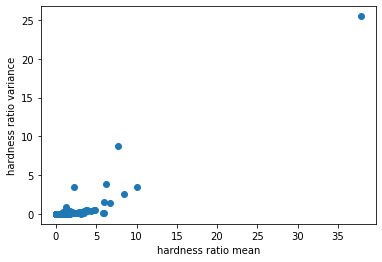

In [31]:
plt.scatter(hardness_ratio_mean,hardness_ratio_variance)
plt.xlabel('hardness ratio mean');
plt.ylabel('hardness ratio variance');

Now this is interesting!  What is that outlier?

In [32]:
tgts_flat_unique[hardness_ratio_mean>35.]

array(['X1630-472'], dtype='<U24')

Plot the hard and soft X-ray light curves of X1630-472

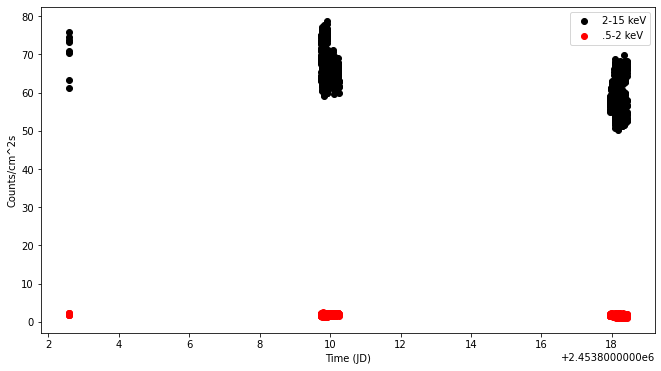

In [33]:
idx=tgtlabels_unique.index('X1630-472')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend();
plt.xlabel('Time (JD)');
plt.ylabel('Counts/cm^2s');

We can see a pretty substantial decrease in the hardness ratio over time.  Plot it directly.

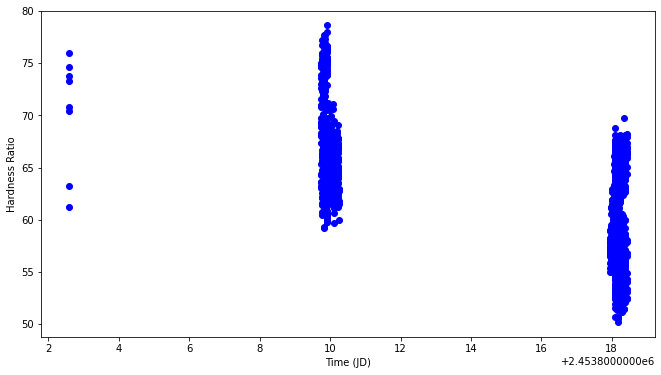

In [34]:
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='b',label='ratio')
plt.xlabel('Time (JD)');
plt.ylabel('Hardness Ratio');

A hardness ratio in the range 50-80 is indeed pretty substantial.  There is more to investigate here, but for now let's investigate the other interesting targets in the hardness ratio plot.

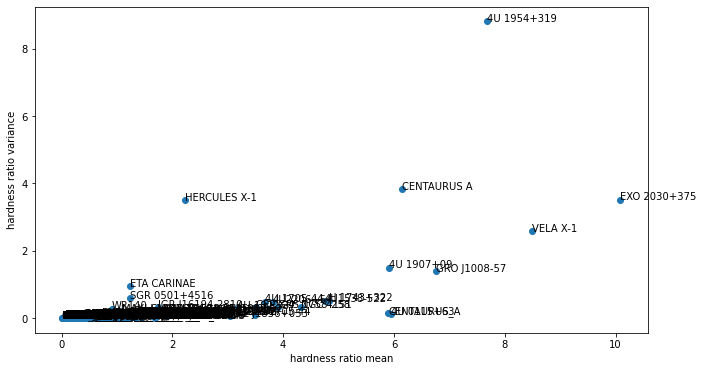

In [35]:
plt.figure(figsize=(11,6))
plt.scatter(hardness_ratio_mean[hardness_ratio_mean<20.],hardness_ratio_variance[hardness_ratio_mean<20.])
plt.xlabel('hardness ratio mean')
plt.ylabel('hardness ratio variance')
for i, txt in enumerate(tgts_flat_unique[hardness_ratio_mean<20.].tolist()):
    plt.annotate(txt, (hardness_ratio_mean[hardness_ratio_mean<20.][i], hardness_ratio_variance[hardness_ratio_mean<20.][i]))

This could be hours of fun!  Check out Her X-1, with a pretty impressive 2:1 ratio of mean to variance in the hardness ratio.

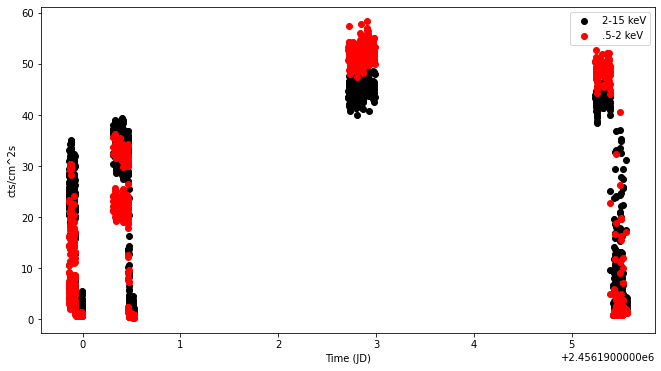

In [36]:
idx=tgtlabels_unique.index('HERCULES X-1')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

Zoom in

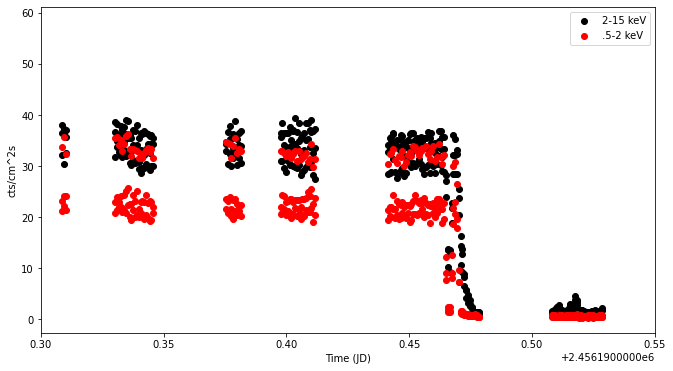

In [37]:
idx=tgtlabels_unique.index('HERCULES X-1')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');
plt.xlim(2456190.3,2456190.55);

Neat, lots to learn here! But, let's continue with the broader analysis.  What happens if we perform Principal Component Analysis on an array of the light curves?

In [38]:
lenmask=[True if len(lc)>64 else False for lc in lcs_hard]
lcs_hard_64=np.array(lcs_hard)[lenmask].tolist()
lcs_hard_64=np.array([lc[:64] for lc in lcs_hard_64])
lcs_soft_64=np.array(lcs_soft)[lenmask].tolist()
lcs_soft_64=np.array([lc[:64] for lc in lcs_soft_64])
times_64=np.array(times)[lenmask].tolist()
times_64=np.array([lc[:64] for lc in times_64])
tgtlabels_64=np.array(tgtlabels)[lenmask].tolist()
tgtlabels_64=np.array([lc[:64] for lc in tgtlabels_64])

In [39]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2,random_state=1234)
hpca=pca.fit_transform(lcs_hard_64)
pca=PCA(n_components=2,random_state=1234)
spca=pca.fit_transform(lcs_soft_64)

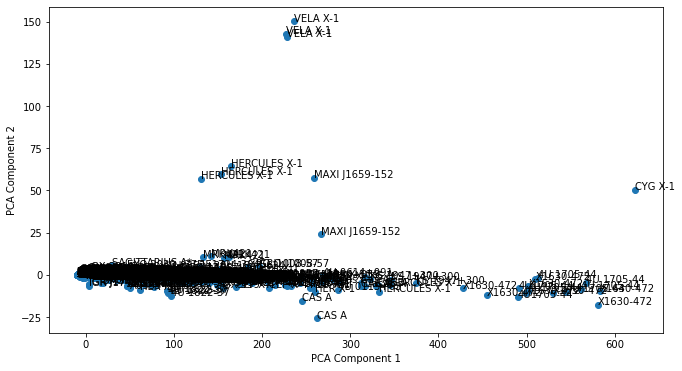

In [40]:
plt.figure(figsize=(11,6))
plt.scatter(hpca[:,0],hpca[:,1])
for i, txt in enumerate(tgtlabels_64.tolist()):
    plt.annotate(txt, (hpca[i,0], hpca[i,1]))
plt.xlabel('PCA Component 1');
plt.ylabel('PCA Component 2');

PCA preserves global distance from the higher dimensional data, so it's a great tool to identify outliers, but not necessarily relationships between the outliers.  We've already looked at Her X-1 and Cyg X-1, so we can see that PCA also identifies Vela X-1 and MAXI J1659-152 as "odd", so let's take a look.

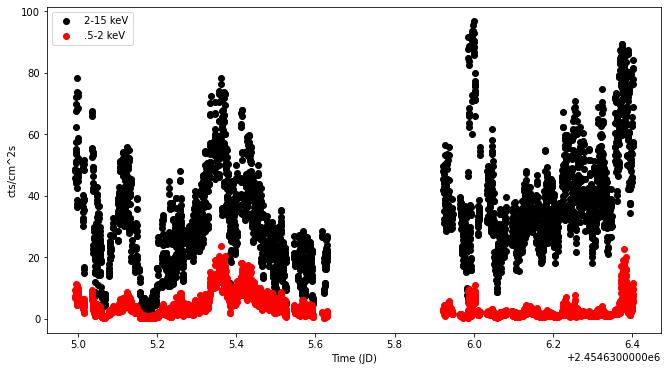

In [41]:
idx=tgtlabels_unique.index('VELA X-1')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

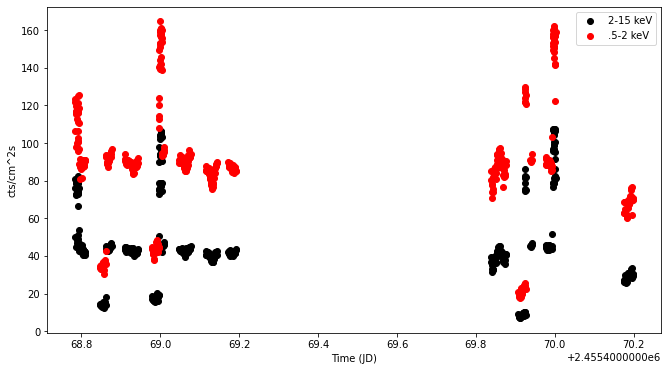

In [42]:
idx=tgtlabels_unique.index('MAXI J1659-152')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

Indeed, these light curves are quite interesting.  Another method of dimensionality reduction is TSNE.  Try it.

In [43]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,random_state=1234)
htsne=tsne.fit_transform(lcs_hard_64)
tsne=TSNE(n_components=2,random_state=1234)
stsne=tsne.fit_transform(lcs_soft_64)

/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


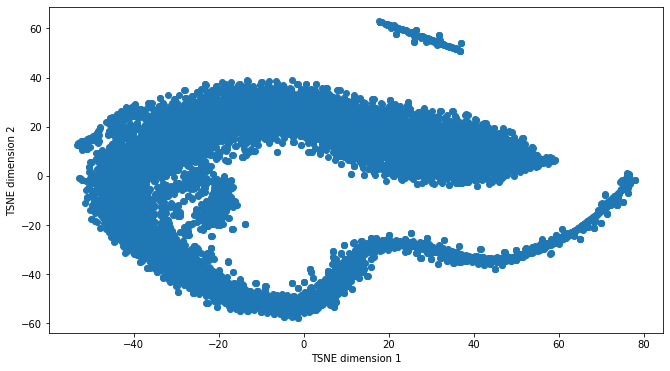

In [44]:
plt.figure(figsize=(11,6));
plt.scatter(htsne[:,0],htsne[:,1]);
plt.xlabel('TSNE dimension 1');
plt.ylabel('TSNE dimension 2');

TSNE is a heuristic that attempts to preserve local distance in the higher dimension rather than global.  The dimensions are arbitrary and meaning can only extracted from proximity.  So, let's look at the outlier group.

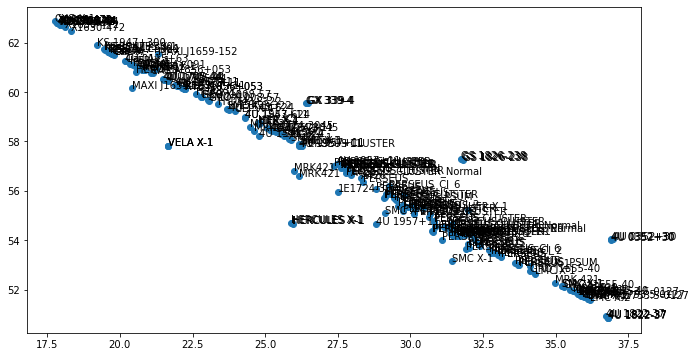

In [45]:
plt.figure(figsize=(11,6))
mask=htsne[:,1]>45.
plt.scatter(htsne[mask,0],htsne[mask,1])
for i, txt in enumerate(tgtlabels_64[mask].tolist()):
    plt.annotate(txt, (htsne[mask][i,0], htsne[mask][i,1]))

We are looking for similar characteristics among these sources, but obvious meaning is not apparent.  What are the identities of the included sources?

In [46]:
np.unique(tgtlabels_64[mask])

array(['1E1724-3045', '4U 0115+63', '4U 0352+30', '4U 0614+091',
       '4U 1543-624', '4U 1705-44', '4U 1822-37', '4U 1957+11',
       '4U1705-44', 'A426', 'CAS A', 'CEP X-4', 'CYG X-1', 'Cas A',
       'GRO J1008-57', 'GRO J1655-40', 'GS 1826-238', 'GX 339-4',
       'H 1743+322', 'HER X-1', 'HERCULES X-1', 'Her X-1', 'KS 1947+300',
       'LMC X-1', 'LMC X-2', 'LMC X-3', 'MAXI J1659-152', 'MRK 421',
       'MRK421', 'PERSEUS', 'PERSEUS CLUSTER', 'PERSEUS_1_4_WIN',
       'PERSEUS_CI_2', 'PERSEUS_CI_6', 'PERSEUS_CLUSTER_Normal',
       'PERSEUS_PSUM', 'SMC X-1', 'SWIFT J1753.5-0127', 'VELA X-1',
       'X1630-472', 'XTE J1856+053'], dtype='<U24')

Plot a few of these light curves, try to pick out the similarities that TSNE would have latched on to in the reduction.

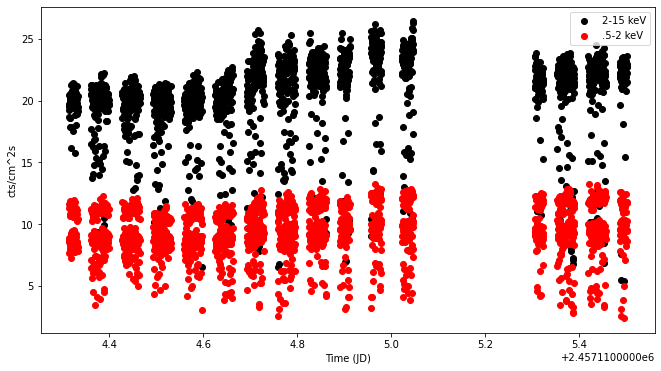

In [47]:
idx=tgtlabels_unique.index('1E1724-3045')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

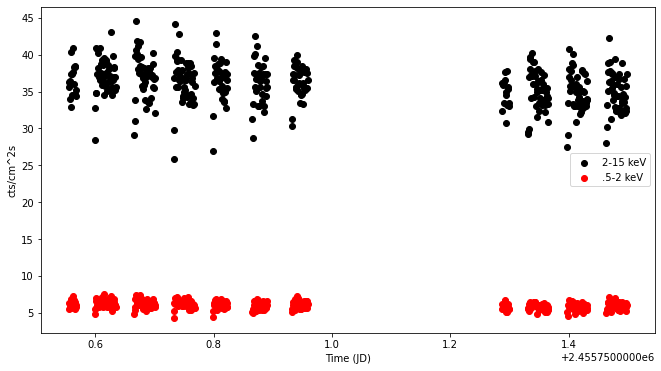

In [48]:
idx=tgtlabels_unique.index('4U 0115+63')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

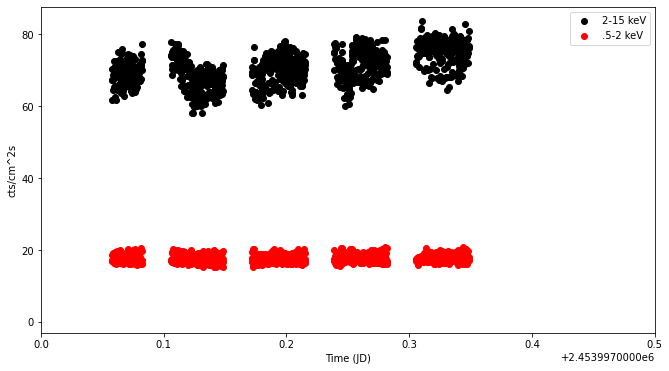

In [49]:
idx=tgtlabels_unique.index('4U 1705-44')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');
plt.xlim(2453997,2453997.5);

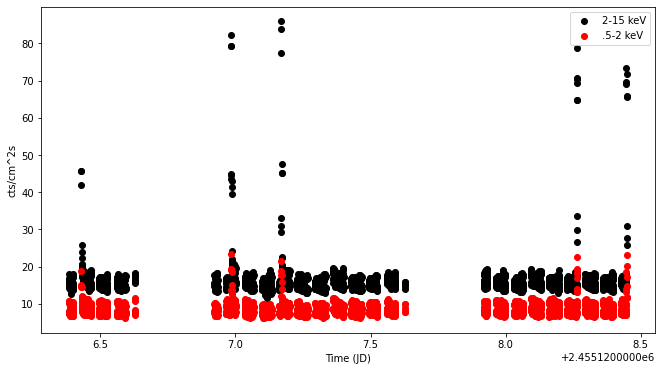

In [50]:
idx=tgtlabels_unique.index('GS 1826-238')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

We can generally see hard X-ray emission is greater than soft X-ray emission.  That may be the only thing PCA is capable of here.  what can we do to find more intelligent represenations?  If we want to analyze the behavior of the sources, neglecting the magnitude, we need to scale the data.   The scikit-learn library offers a variety of options on this front.  Here, use the standard scaler, creating nicely Gaussian light curves.

In [51]:
from sklearn.preprocessing import StandardScaler
lcs_hard_64_scaled=[]
for i in range(lcs_hard_64.shape[0]):
    s=StandardScaler()
    lcs_hard_64_scaled.append(s.fit_transform(lcs_hard_64[i].reshape(-1,1)).T[0])
lcs_soft_64_scaled=[]
for i in range(lcs_soft_64.shape[0]):
    s=StandardScaler()
    lcs_soft_64_scaled.append(s.fit_transform(lcs_soft_64[i].reshape(-1,1)).T[0])
lcs_hard_64_scaled=np.array(lcs_hard_64_scaled)
lcs_soft_64_scaled=np.array(lcs_soft_64_scaled)

Then, try TSNE again.  What's different?

In [ ]:
tsne=TSNE(n_components=2,random_state=1234)
htsne=tsne.fit_transform(lcs_hard_64_scaled)
tsne=TSNE(n_components=2,random_state=1234)
stsne=tsne.fit_transform(lcs_soft_64_scaled)
plt.figure(figsize=(11,6));
plt.scatter(htsne[:,0],htsne[:,1]);
plt.xlabel('TSNE dimension 1');
plt.ylabel('TSNE dimension 2');

/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jovyan/users_conda_envs/tf_test/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Well, that went as expected.  A bunch of Gaussian light curves will create a Gaussian space.  We have very little to learn from this representation.  However, what happens if we learn a more intelligent representation through an autoencoder neural network?  Although light curves are a temporal process, here let's ignore that and allow the autoencoder to analyze the numerical replationships without the complexity of time.  We are just exploring after all.

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *

In [ ]:
%%time

inputlayer=Input(64,)
x=Dense(64,activation='tanh')(inputlayer)
x=Dense(32,activation='relu')(x)
x=Dense(16,activation='relu')(x)
encoded=Dense(8,activation='relu')(x)
x=Dense(16,activation='relu')(encoded)
x=Dense(32,activation='relu')(x)
outputlayer=Dense(64,activation='linear')(x)
model=Model(inputs=[inputlayer],outputs=[outputlayer])
encoder=Model(inputs=[inputlayer],outputs=[encoded])
model.compile(loss='mse',optimizer='rmsprop')
modelcheckpoint=ModelCheckpoint(weightpath+'suzaku_hard_lc.weights', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlystopping=EarlyStopping(monitor='loss', min_delta=0., patience=20, verbose=0, mode='auto')
model.fit(lcs_hard_64_scaled,lcs_hard_64_scaled,epochs=1000,callbacks=[modelcheckpoint,earlystopping]);
model.load_weights(weightpath+'suzaku_hard_lc.weights')

Use the encoded representation as input to TSNE

In [ ]:
tsne=TSNE(n_components=2,random_state=1234)
ehstsne=tsne.fit_transform(encoder.predict(lcs_hard_64_scaled))
plt.figure(figsize=(11,6));
plt.scatter(ehstsne[:,0],ehstsne[:,1]);
plt.xlabel('TSNE dimension 1');
plt.ylabel('TSNE dimension 2');

Beautiful! A simple encoding turned an unintelligible blob into several very distinct groupings!  Cluster them using the DBSCAN method.

In [ ]:
from sklearn.cluster import DBSCAN
dbs=DBSCAN(eps=2.1)
labels=dbs.fit_predict(ehstsne)
plt.figure(figsize=(11,6))
for i in range(1,labels.max()):
    plt.scatter(ehstsne[labels==i,0],ehstsne[labels==i,1])

Now let's look at one of these groups to see if it acutally makes sense.  Your run of the neural net will be different, so the groupings will not be consistent.  One of my groups contained 'A1750S','ABELL 426 NNE7','EK TRA', and 'E0102.2-7219'.  Analyzing this group below.

Plot the light curves

In [ ]:
idx=tgtlabels_unique.index('A1750S')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

In [ ]:
idx=tgtlabels_unique.index('ABELL 426 NNE7')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

In [ ]:
idx=tgtlabels_unique.index('EK TRA')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

In [ ]:
idx=tgtlabels_unique.index('E0102.2-7219')
plt.figure(figsize=(11,6))
plt.scatter(Time(timeconvert(idx,'hard')[0], format='isot', scale='utc').jd,timeconvert(idx,'hard')[1],c='k',label='2-15 keV')
plt.scatter(Time(timeconvert(idx,'soft')[0], format='isot', scale='utc').jd,timeconvert(idx,'soft')[1],c='r',label='.5-2 keV')
plt.legend()
plt.xlabel('Time (JD)');
plt.ylabel('cts/cm^2s');

Wow, these all demonstrate VERY similar light curves in an extremely stable long-term environment.  Sure enough, the known calibration source E0102.2-7219 is among them!  It may be worth looking at these other sources as possible calibration targets, thanks ML!

Now that we've had some fun with the light curves, let's examine the spectra from Suzaku with yet another HEASARC pre-curated data set.

In [ ]:
fp=open(path+'suzaku_specs.pkl','rb');specs=pickle.load(fp);fp.close()
fp=open(path+'suzaku_specs_tgtlabels.pkl','rb');spec_labels=pickle.load(fp);fp.close()

In [ ]:
specs=np.array(specs)
spec_labels=np.array(spec_labels)

In [ ]:
specs.shape

This is an array of 3040 spectra, each of length 1024. These spectra were extracted from raw observation data and interpolated to energies corresponding to the following array, 'xref', for the purposes of standardization for ML.

In [ ]:
xref=np.arange(.5,15.,.01)
xref=xref[:1024]

Let's examine a few spectra.  To do so, define a function for plotting a spectrum, which is usually viewed in a log-log plot.  Then, randomly choose a few spectra.

In [ ]:
def spectrum_plot(idx):
    plt.figure(figsize=(11,6))
    plt.plot(xref,specs[idx])
    plt.title(spec_labels[idx])
    plt.xlabel('Energy (keV)');
    plt.ylabel('cts/cm^2s/keV');
    plt.semilogx();
    plt.semilogy();

In [ ]:
spectrum_plot(93)

In [ ]:
spectrum_plot(1800)

In [ ]:
spectrum_plot(455)

Interesting.  The first and third spectra above (GRS 1915+105 and 4U 1705-44) are quite similar.  These are a black hole binary and a neutron star binary, respectively, but both fall into a the category of Low-Mass X-ray Binaries (LMXB).  Can we build a classifier using AI/ML to find other LMXBs in the data set?  Let's find out.

First, find all the spectra for these two sources.

In [ ]:
spec_labels[spec_labels=='4U 1705-44']

In [ ]:
spec_labels[spec_labels=='4U1705-44']

There is some difficulty here in the formatting of the label, so let's reduce the label to only lowercase alphanumeric characters.

In [ ]:
spec_labels=np.array([''.join([i for i in t if i.isalpha() or i.isnumeric()]).lower() for t in spec_labels])

In [ ]:
spec_labels[spec_labels=='4u170544']

In [ ]:
spec_labels[spec_labels=='grs1915105']

We have 10 total samples for these LMXBs, which isn't great for AI/ML training purposes, but let's try to train a neural network and see what happens. First, like we did for the light curves, we scale the spectra so that the neural network can interpret features rather than magnitudes.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
specs_scaled=[]
for i in range(specs.shape[0]):
    s=MinMaxScaler()
    specs_scaled.append(s.fit_transform(specs[i].reshape(-1,1)).T[0])
specs_scaled=np.array(specs_scaled)

Now, create the train and test data sets.

In [ ]:
xtrain_pos_idx=(spec_labels=='4u170544') | (spec_labels=='grs1915105') | (spec_labels=='aqlx1') | (spec_labels=='gx172')
xtrain_neg_idx=(spec_labels=='ngc3227') | (spec_labels=='abell426nne7') | (spec_labels=='1e17243045') | (spec_labels=='a1750s') | (spec_labels=='casa') | (spec_labels=='crab')
xtrain_pos=specs[xtrain_pos_idx]
xtrain_neg=specs[xtrain_neg_idx]
xtrain_pos_labels=spec_labels[xtrain_pos_idx]
xtrain_neg_labels=spec_labels[xtrain_neg_idx]
ytrain_pos=np.ones(xtrain_pos.shape[0])
ytrain_neg=np.zeros(xtrain_neg.shape[0])
xtrain=np.vstack((xtrain_pos,xtrain_neg))
xtrain_labels=np.hstack((xtrain_pos_labels,xtrain_neg_labels))
ytrain=np.hstack((ytrain_pos,ytrain_neg))
xval=specs[~(xtrain_pos_idx | xtrain_neg_idx)]
xval_labels=spec_labels[~(xtrain_pos_idx | xtrain_neg_idx)]
xtrain=np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))
xval=np.reshape(xval,(xval.shape[0],xval.shape[1],1))

We will be training this neural network without a test set.  For actual use purposes, this is not practical.  However, we simply want to see if this data contains any predictive power as a quick test.  We will use a 1D Convolutional Neural Network (CNN), which will allow the neural network to identify particular shapes in the spectrum rather than focusing on the values at specific energies.

In [ ]:
%%time

inputlayer=Input(shape=(1024,1))
x=Conv1D(16,kernel_size=4,strides=1,padding='same')(inputlayer)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=.1)(x)
x=Dropout(.5)(x)
x=Conv1D(32,kernel_size=4,strides=1,padding='same')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=.1)(x)
x=Dropout(.5)(x)
x=Conv1D(64,kernel_size=4,strides=1,padding='same')(x)
x=BatchNormalization()(x)
x=LeakyReLU(alpha=.1)(x)
x=Flatten()(x)
x=Dropout(.5)(x)
outputlayer=Dense(1,activation='sigmoid')(x)
model=Model(inputs=[inputlayer],outputs=[outputlayer])
model.compile(loss='binary_crossentropy',optimizer='rmsprop')
modelcheckpoint=ModelCheckpoint(weightpath+'suzaku_spectrum_classifier.weights', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
earlystopping=EarlyStopping(monitor='loss', min_delta=0., patience=20, verbose=0, mode='auto')
model.fit(xtrain,ytrain,epochs=1000,callbacks=[modelcheckpoint,earlystopping]);
model.load_weights(weightpath+'suzaku_spectrum_classifier.weights')

Now that the neural network has trained, let's predict the validation set and see what happens.  Remember that we are interested in output values near 1, which means the neural net "thinks" that the spectrum is very similar to known X-ray binaries.

In [ ]:
p=model.predict(xval)
plt.figure(figsize=(11,6))
plt.hist(p,bins=100);
plt.xlabel('Predicted Score');
plt.ylabel('Number of Samples');
plt.semilogy();

Most outputs were near 0.5, which means that the neural network has no ability to predict whether or not the spectrum is from an X-ray binary.  This is expected based on the poor training set.  However, there are a few with scores near 1.  Let's find out what they are.

In [ ]:
xval_labels[p[:,0]>.8]

Your outputs will be slightly different based on the training randomization.  My spectra with scores greater than 0.8 are:

GX 349-2,
X 1630-472,
Cyg X-3,
Serpens X-1,
4U 1636-536,
Cyg X-1,
GX 340-0,
4U 1608-52,
A 0535+26,
4U 1820-30,
GX 99,
GX 304-1,
4U 1735-44,
GRO J100857,
GRO J174428

Some quick research shows that all except for two of these sources are LMXBs!  This test effort was wildly successful at showing that:

1. X-ray Binaries possess similar X-ray spectra
2. A neural network is highly capable of classifying LMXBs by their spectra.

We learned here that we can take a pre-curated HEASARC data set and do some really neat analyses of a lot of X-ray light curves and spectra.  All these sources, however, are known and well-researched.  Can we use the HEASARC data set to go "fishing" inside the big XMM and Chandra catalogs for unknown sources???  Tune in next episode...